# Hodographs

To-do next:
- Plot shear vector on hodographs
- Calculate the bunkers storm motion vector

## Setup

In [55]:
# Import statements
import xarray as xr
import matplotlib.pyplot as plt
from typing import List, Tuple
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from metpy.plots import Hodograph
from metpy.units import units
import numpy as np
import numpy.typing as npt
from matplotlib.patches import Rectangle

plt.style.use("dark_background")


In [62]:
# Define useful functions
def get_wofs_all(init: int) -> xr.Dataset:
    """Read in WoFS output based on initialization time."""
    file_pattern = f"/mnt/drive2/new-wofs/{init:02d}Z/wofs_ALL*.nc"
    loaded = xr.open_mfdataset(
        file_pattern, combine="nested", concat_dim="time", chunks="auto"
    )

    if init < 6:
        start_time = f"2021-09-02 {init:02d}:00:00"
        end_time = f"2021-09-02 {init + 6:02d}:00:00"
    else:
        start_time = f"2021-09-01 {init:02d}:00:00"
        end_time = f"2021-09-02 {init - 24 + 6:02d}:00:00"

    loaded["time"] = xr.cftime_range(start_time, end_time, freq="5min")
    return loaded


def calculate_layer_mean_wind(u, v, z, z_min=0, z_max=6000):
    mask = (z.values < z_max) & (z_min < z.values)
    u_masked = u[mask]
    v_masked = v[mask]
    z_masked = z[mask]

    if int(mask.sum()) > 1:
        # Calculate the thickness of each layer (difference in adjacent heights)
        layer_thickness = np.diff(z_masked)
        layer_thickness = np.append(
            layer_thickness, layer_thickness[-1]
        )  # Assume last layer has same thickness

        # Calculate weighted means for u and v components
        layer_mean_u = np.average(u_masked, weights=layer_thickness)
        layer_mean_v = np.average(v_masked, weights=layer_thickness)
    elif int(mask.sum() == 1):
        layer_mean_u = u_masked.values[0]
        layer_mean_v = v_masked.values[0]

    return np.array((layer_mean_u, layer_mean_v))


# Make function to calculate shear vector
def calculate_shear_vector(
    u: xr.DataArray, v: xr.DataArray, z: xr.DataArray
) -> npt.NDArray[np.float64]:
    # Calculate the 0-500m mean wind
    bottom = calculate_layer_mean_wind(u, v, z, z_min=0, z_max=500)

    # The 5.5-6km mean wind
    top = calculate_layer_mean_wind(u, v, z, z_min=5500, z_max=6000)

    # Shear is the difference between the two
    shear = top - bottom

    return shear

# Calculate Bunkers right-mover storm motion vector
def calculate_bunker_rm(
        mean: npt.NDArray[np.float64], shear: npt.NDArray[np.float64]
) -> npt.NDArray[np.float64]:
    
    # rotate the shear by 90 deg clockwise for right mover and normalize
    ortho_vec = np.array((shear[1], shear[0] * -1)) / np.linalg.norm(shear)

    # multiply by 7.5 and add to mean wind
    b_rm = mean + 7.5 * ortho_vec
    return b_rm


def plot_hodographs_and_map(
    u_wet,
    v_wet,
    z_wet,
    u_dry,
    v_dry,
    z_dry,
    u_wet_mean,
    v_wet_mean,
    z_wet_mean,
    u_dry_mean,
    v_dry_mean,
    z_dry_mean,
    lat_coarse,
    lon_coarse,
    nx_ind,
    ny_ind,
    suptitle="NNJ",
):
    fig, axes = plt.subplots(1, 2, figsize=(5.5, 3), dpi=300, layout="constrained")

    us = [
        u_wet.stack(dict(run=("init", "ne"))).transpose("run", "nz"),
        u_dry.stack(dict(run=("init", "ne"))).transpose("run", "nz"),
    ]
    vs = [
        v_wet.stack(dict(run=("init", "ne"))).transpose("run", "nz"),
        v_dry.stack(dict(run=("init", "ne"))).transpose("run", "nz"),
    ]
    zs = [
        z_wet.stack(dict(run=("init", "ne"))).transpose("run", "nz"),
        z_dry.stack(dict(run=("init", "ne"))).transpose("run", "nz"),
    ]
    mean_us = [u_wet_mean, u_dry_mean]
    mean_vs = [v_wet_mean, v_dry_mean]
    mean_zs = [z_wet_mean, z_dry_mean]
    titles = ["00 UTC, Wet Ensemble", "00 UTC, Dry Ensemble"]

    # Define height ranges in meters and corresponding colors
    height_ranges = [
        (9000, 12000, "purple", "9-12km"),
        (6000, 9000, "blue", "6-9km"),
        (3000, 6000, "green", "3-6km"),
        (1000, 3000, "orange", "1-3km"),
        (0, 1000, "red", "0-1km"),
    ]

    for i, ax in enumerate(axes.flatten()):
        hodograph = Hodograph(ax, component_range=60)
        hodograph.add_grid(increment=10)

        # Mask values above 12km for gray lines
        mask = mean_zs[i].values < 12000
        for ens in range(us[i].shape[0]):
            hodograph.plot_colormapped(
                us[i][ens, mask],
                vs[i][ens, mask],
                zs[i][ens, mask],
                color="lightgray",
                linewidth=0.5,
                alpha=0.7,
            )

        # Plot the entire hodograph starting from the highest altitude range down to the lowest
        for z_min, z_max, color, label in height_ranges:
            mask = mean_zs[i].values < z_max
            hodograph.plot_colormapped(
                mean_us[i][mask],
                mean_vs[i][mask],
                mean_zs[i][mask],
                color=color,
                label=label,
            )

        # Calculate and plot the layer mean wind (0-12km) using weighted mean
        layer_mean_u, layer_mean_v = calculate_layer_mean_wind(
            mean_us[i], mean_vs[i], mean_zs[i]
        )
        ax.arrow(
            0,
            0,
            layer_mean_u,
            layer_mean_v,
            color="white",
            head_width=2,
            head_length=3,
            linewidth=1.5,
            length_includes_head=True,
            zorder=5,
        )

        # Calculate shear
        shear = calculate_shear_vector(
            mean_us[i], mean_vs[i], mean_zs[i]
        )

        # And bunker storm motion vector
        b_rm_u, b_rm_v = calculate_bunker_rm(np.array((layer_mean_u,layer_mean_v)),shear)

        ax.arrow(
            0,
            0,
            b_rm_u,
            b_rm_v,
            color="goldenrod",
            head_width=2,
            head_length=3,
            linewidth=1.5,
            length_includes_head=True,
            zorder=5,
        )

        # Add circle labels at 10, 20, 30, 40, 50, 60
        circle_labels = np.arange(10, 70, 10)
        for label in circle_labels:
            ax.text(label, 0, str(label), fontsize=6, ha="center", va="top")
        # Remove the axis labels and ticks
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel("")
        ax.set_ylabel("")

        ax.set_title(titles[i], fontsize=8)

    ax1 = fig.add_axes([0.8, -0.1, 0.2, 0.4], projection=proj)
    # Add state boundaries
    ax1.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="white", zorder=4)

    # Set the extent of the map to focus on the region of interest
    ax1.set_extent(
        [lon_coarse.min(), lon_coarse.max(), lat_coarse.min(), lat_coarse.max()],
        crs=ccrs.PlateCarree(),
    )

    # Add the red box over the grid box of interest
    box_width = lon_coarse[0, 1] - lon_coarse[0, 0]  # Assuming evenly spaced grid
    box_height = lat_coarse[1, 0] - lat_coarse[0, 0]  # Assuming evenly spaced grid
    rect = Rectangle(
        (
            lon_coarse[nx_ind, ny_ind] - box_width / 2,
            lat_coarse[nx_ind, ny_ind] - box_height / 2,
        ),
        box_width,
        box_height,
        linewidth=0.6,
        edgecolor="red",
        facecolor="none",
        transform=ccrs.PlateCarree(),
        zorder=3,
    )
    ax1.add_patch(rect)

    axes[0].legend(fontsize=6, loc="upper right")  # type: ignore
    plt.suptitle(suptitle, fontsize=8, fontweight="bold")
    plt.show()


def extract_data(
    var: str, ne_index: List[xr.DataArray] | xr.DataArray, ny_ind: int, nx_ind: int
) -> List[xr.DataArray]:
    return [
        w[var]
        .sel(time="2021-09-02 00:00:00", ne=n)
        .isel(ny=ny_ind, nx=nx_ind)
        .squeeze()
        .load()
        * units("m/s" if var in ["u", "v"] else "m")
        for w, n in zip(wofs_all, ne_index)
    ]


In [3]:
# Read in 20-23Z initializations
wofs_all = [get_wofs_all(n) for n in range(20,24,1)]

In [4]:
# Define variables and parameters
lat = wofs_all[0].xlat.isel(time=0).squeeze().drop_vars("time")
lon = wofs_all[0].xlon.isel(time=0).squeeze().drop_vars("time")

lat_coarse = (
    wofs_all[0]
    .xlat_snd.isel(time=0)
    .squeeze()
    .drop_vars("time")
    .rename(dict(dim_0="ny", dim_1="nx"))
)
lon_coarse = (
    wofs_all[0]
    .xlon_snd.isel(time=0)
    .squeeze()
    .drop_vars("time")
    .rename(dict(dim_0="ny", dim_1="nx"))
)

# Set up Cartopy projection
proj = ccrs.LambertConformal(
    central_longitude=wofs_all[0].attrs["CEN_LON"],
    central_latitude=wofs_all[0].attrs["CEN_LAT"],
    standard_parallels=(30, 60),
)  # WoFS projection

# Create a DataArray for the initialization dimension
init = xr.DataArray(data=["20Z", "21Z", "22Z", "23Z"], dims="init").assign_coords(
    {"init": ["20Z", "21Z", "22Z", "23Z"]}
)


## Get the 5 wettest and driest ensemble members


In [5]:
# Set desired latitude and longitude (Central Park)
nyc_lat, nyc_lon = 40.7826, -73.9656

# Calculate Euclidean distance and find the nearest indices
distance = np.sqrt((lat - nyc_lat) ** 2 + (lon - nyc_lon) ** 2)
nyc_inds = distance.argmin(dim=["NY", "NX"])
lat_ind, lon_ind = int(nyc_inds["NY"]), int(nyc_inds["NX"])

# Calculate the 1-2 UTC rainfall
rain12 = [w.rain.sel(
    time=slice("2021-09-02 01:05:00", "2021-09-02 02:00:00")
).sum(dim="time") for w in wofs_all]

# Extract the rainfall value in NYC
rain12_nyc = [r.isel(lat=lat_ind, lon=lon_ind) for r in rain12]

# Grab the 5 wettest and driest ensemble members
ranking = [r.ne.sortby(r).load() for r in rain12_nyc]
driest, wettest = [r[:5] for r in ranking], [r[-5:] for r in ranking]

# print(driest,wettest)

## Compare wettest and driest ensemble members

### NNJ

In [63]:
# First, find the nx and ny closest to, say, Morristown
mor_lat, mor_lon = 40.7968, -74.4815

# Calculate Euclidean distance and find the nearest indices
distance = np.sqrt((lat_coarse - mor_lat) ** 2 + (lon_coarse - mor_lon) ** 2)
mor_inds = distance.argmin(dim=["ny", "nx"])
ny_ind, nx_ind = int(mor_inds["nx"]), int(mor_inds["ny"])

u_wet = xr.concat(extract_data("u", wettest, ny_ind, nx_ind), dim=init)
v_wet = xr.concat(extract_data("v", wettest, ny_ind, nx_ind), dim=init)
z_wet = xr.concat(extract_data("z_agl", wettest, ny_ind, nx_ind), dim=init)

u_dry = xr.concat(extract_data("u", driest, ny_ind, nx_ind), dim=init)
v_dry = xr.concat(extract_data("v", driest, ny_ind, nx_ind), dim=init)
z_dry = xr.concat(extract_data("z_agl", driest, ny_ind, nx_ind), dim=init)

# Calculate ensemble means
u_wet_mean, u_dry_mean = u_wet.mean(dim=["ne", "init"]), u_dry.mean(dim=["ne", "init"])
v_wet_mean, v_dry_mean = v_wet.mean(dim=["ne", "init"]), v_dry.mean(dim=["ne", "init"])
z_wet_mean, z_dry_mean = z_wet.mean(dim=["ne", "init"]), z_dry.mean(dim=["ne", "init"])


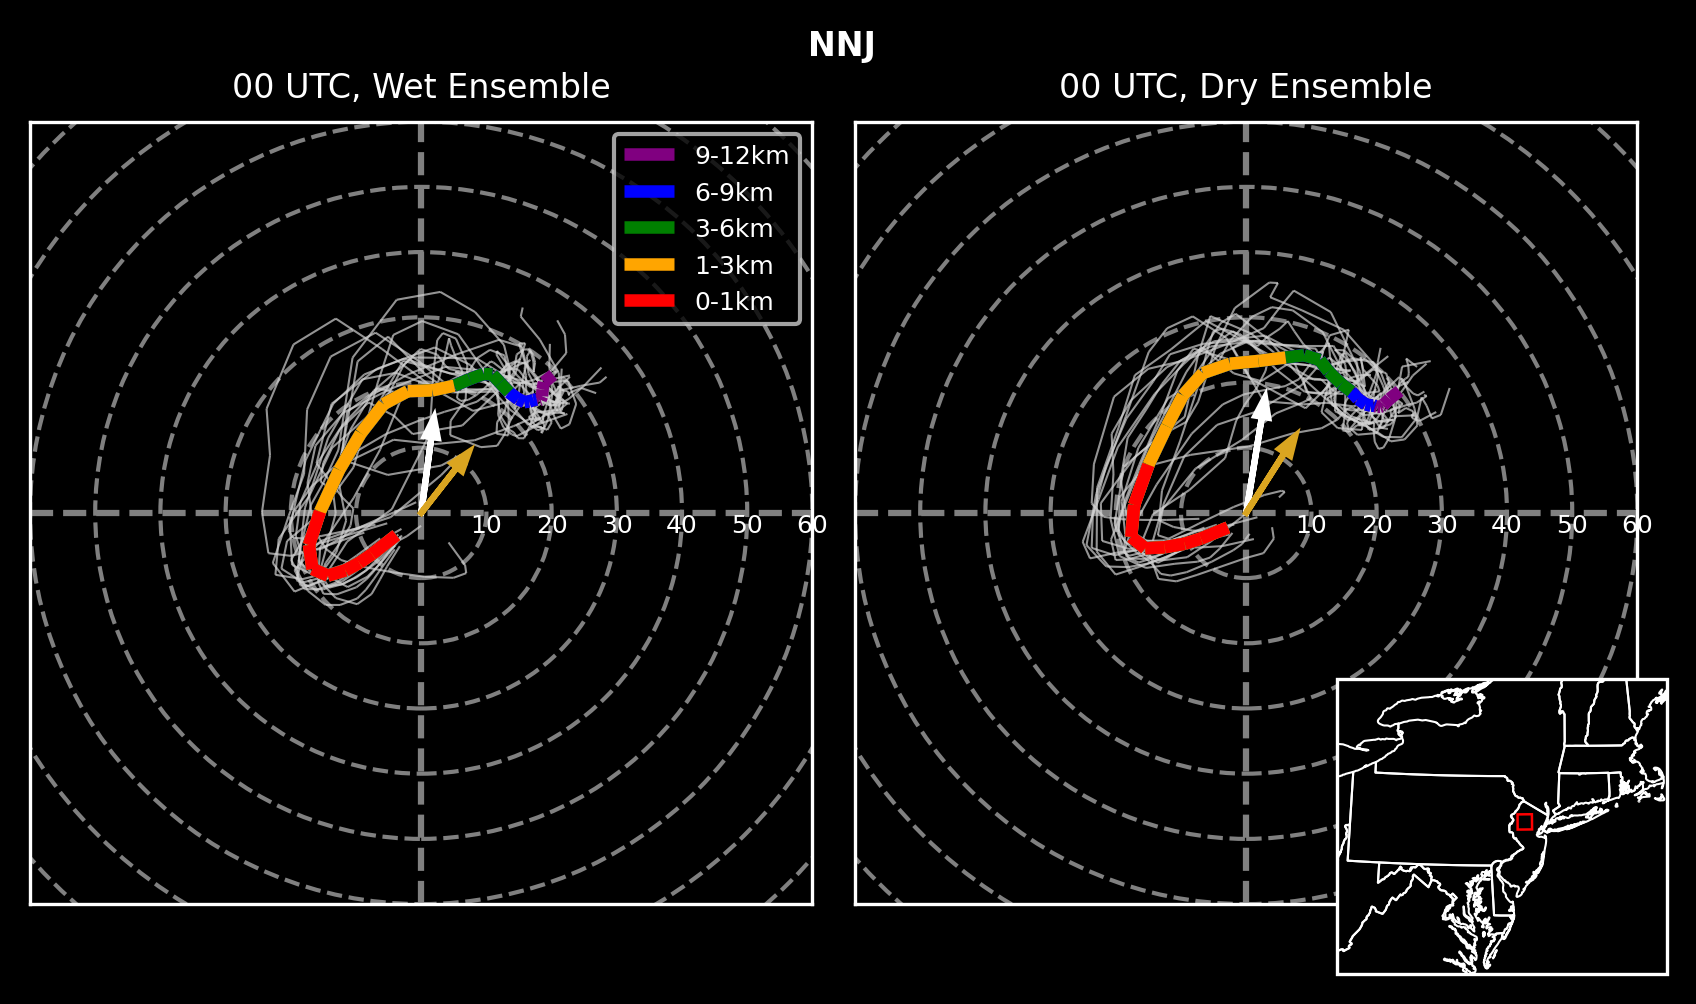

In [64]:
plot_hodographs_and_map(
    u_wet,
    v_wet,
    z_wet,
    u_dry,
    v_dry,
    z_dry,
    u_wet_mean,
    v_wet_mean,
    z_wet_mean,
    u_dry_mean,
    v_dry_mean,
    z_dry_mean,
    lat_coarse,
    lon_coarse,
    nx_ind,
    ny_ind,
    suptitle="NNJ",
)


### SNJ

In [13]:
# First, find the nx and ny closest to, say, Vineland
vin_lat, vin_lon = 39.4864, -75.0260

# Calculate Euclidean distance and find the nearest indices
distance = np.sqrt((lat_coarse - vin_lat) ** 2 + (lon_coarse - vin_lon) ** 2)
vin_inds = distance.argmin(dim=["ny", "nx"])
ny_ind, nx_ind = int(vin_inds["nx"]), int(vin_inds["ny"])

u_wet = xr.concat(extract_data("u", wettest, ny_ind, nx_ind), dim=init)
v_wet = xr.concat(extract_data("v", wettest, ny_ind, nx_ind), dim=init)
z_wet = xr.concat(extract_data("z_agl", wettest, ny_ind, nx_ind), dim=init)

u_dry = xr.concat(extract_data("u", driest, ny_ind, nx_ind), dim=init)
v_dry = xr.concat(extract_data("v", driest, ny_ind, nx_ind), dim=init)
z_dry = xr.concat(extract_data("z_agl", driest, ny_ind, nx_ind), dim=init)

# Calculate ensemble means
u_wet_mean, u_dry_mean = u_wet.mean(dim=["ne", "init"]), u_dry.mean(dim=["ne", "init"])
v_wet_mean, v_dry_mean = v_wet.mean(dim=["ne", "init"]), v_dry.mean(dim=["ne", "init"])
z_wet_mean, z_dry_mean = z_wet.mean(dim=["ne", "init"]), z_dry.mean(dim=["ne", "init"])


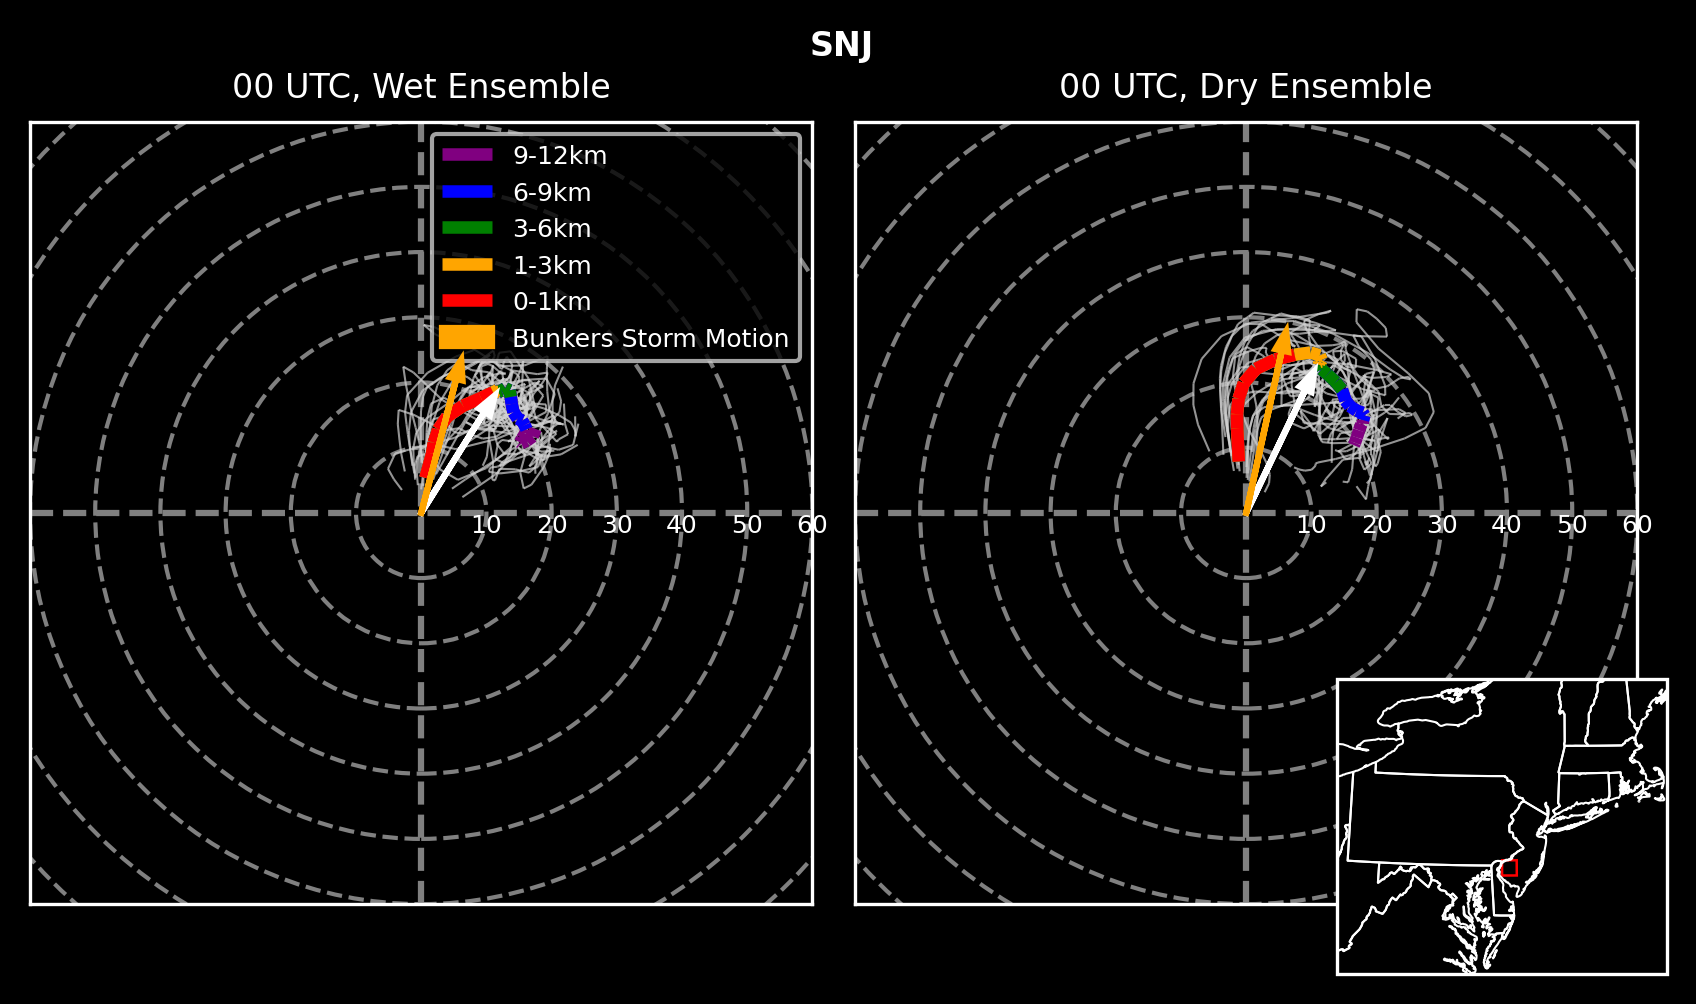

In [14]:
plot_hodographs_and_map(
    u_wet,
    v_wet,
    z_wet,
    u_dry,
    v_dry,
    z_dry,
    u_wet_mean,
    v_wet_mean,
    z_wet_mean,
    u_dry_mean,
    v_dry_mean,
    z_dry_mean,
    lat_coarse,
    lon_coarse,
    nx_ind,
    ny_ind,
    suptitle="SNJ",
)


### AC

In [14]:
# First, find the nx and ny closest to Atlantic City
ac_lat, ac_lon = 39.3643, -74.4229

# Calculate Euclidean distance and find the nearest indices
distance = np.sqrt((lat_coarse - ac_lat) ** 2 + (lon_coarse - ac_lon) ** 2)
vin_inds = distance.argmin(dim=["ny", "nx"])
ny_ind, nx_ind = int(vin_inds["nx"]), int(vin_inds["ny"])

u_wet = xr.concat(extract_data("u", wettest, ny_ind, nx_ind), dim=init)
v_wet = xr.concat(extract_data("v", wettest, ny_ind, nx_ind), dim=init)
z_wet = xr.concat(extract_data("z_agl", wettest, ny_ind, nx_ind), dim=init)

u_dry = xr.concat(extract_data("u", driest, ny_ind, nx_ind), dim=init)
v_dry = xr.concat(extract_data("v", driest, ny_ind, nx_ind), dim=init)
z_dry = xr.concat(extract_data("z_agl", driest, ny_ind, nx_ind), dim=init)

# Calculate ensemble means
u_wet_mean, u_dry_mean = u_wet.mean(dim=["ne", "init"]), u_dry.mean(dim=["ne", "init"])
v_wet_mean, v_dry_mean = v_wet.mean(dim=["ne", "init"]), v_dry.mean(dim=["ne", "init"])
z_wet_mean, z_dry_mean = z_wet.mean(dim=["ne", "init"]), z_dry.mean(dim=["ne", "init"])


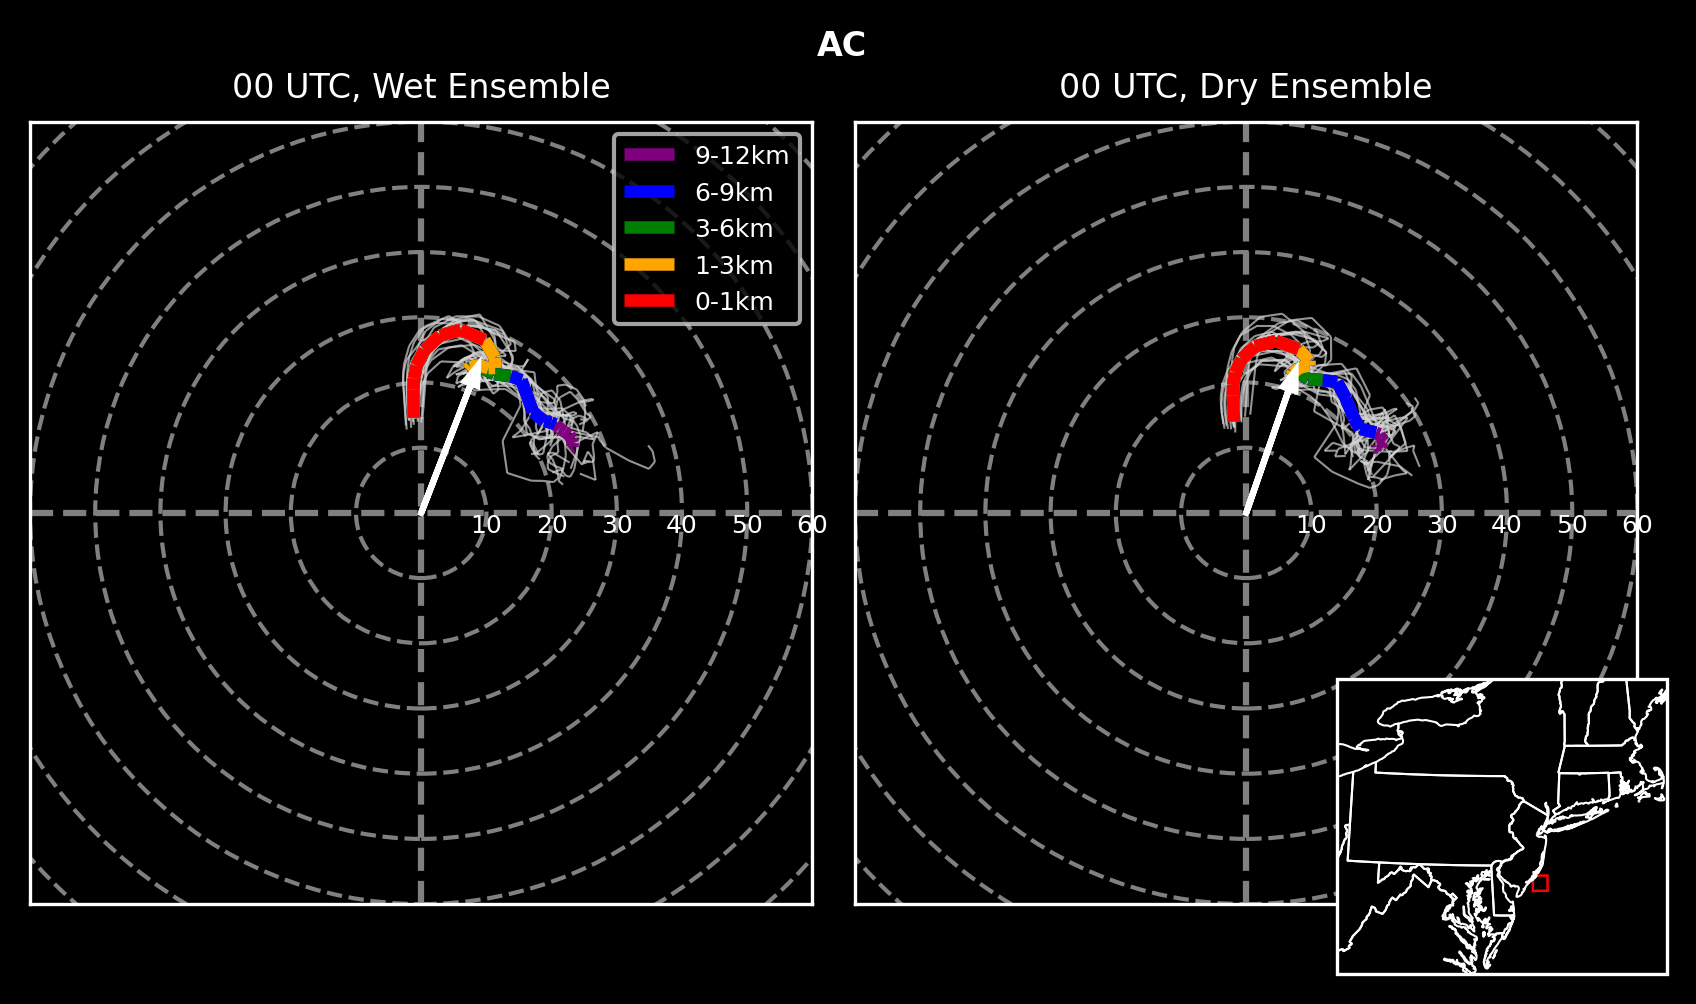

In [15]:
plot_hodographs_and_map(
    u_wet,
    v_wet,
    z_wet,
    u_dry,
    v_dry,
    z_dry,
    u_wet_mean,
    v_wet_mean,
    z_wet_mean,
    u_dry_mean,
    v_dry_mean,
    z_dry_mean,
    lat_coarse,
    lon_coarse,
    nx_ind,
    ny_ind,
    suptitle="AC",
)


### Egg Harbor City

In [16]:
# First, find the nx and ny closest to Atlantic City
ehc_lat, ehc_lon = 39.5287, -74.6479

# Calculate Euclidean distance and find the nearest indices
distance = np.sqrt((lat_coarse - ehc_lat) ** 2 + (lon_coarse - ehc_lon) ** 2)
vin_inds = distance.argmin(dim=["ny", "nx"])
ny_ind, nx_ind = int(vin_inds["nx"]), int(vin_inds["ny"])

u_wet = xr.concat(extract_data("u", wettest, ny_ind, nx_ind), dim=init)
v_wet = xr.concat(extract_data("v", wettest, ny_ind, nx_ind), dim=init)
z_wet = xr.concat(extract_data("z_agl", wettest, ny_ind, nx_ind), dim=init)

u_dry = xr.concat(extract_data("u", driest, ny_ind, nx_ind), dim=init)
v_dry = xr.concat(extract_data("v", driest, ny_ind, nx_ind), dim=init)
z_dry = xr.concat(extract_data("z_agl", driest, ny_ind, nx_ind), dim=init)

# Calculate ensemble means
u_wet_mean, u_dry_mean = u_wet.mean(dim=["ne", "init"]), u_dry.mean(dim=["ne", "init"])
v_wet_mean, v_dry_mean = v_wet.mean(dim=["ne", "init"]), v_dry.mean(dim=["ne", "init"])
z_wet_mean, z_dry_mean = z_wet.mean(dim=["ne", "init"]), z_dry.mean(dim=["ne", "init"])


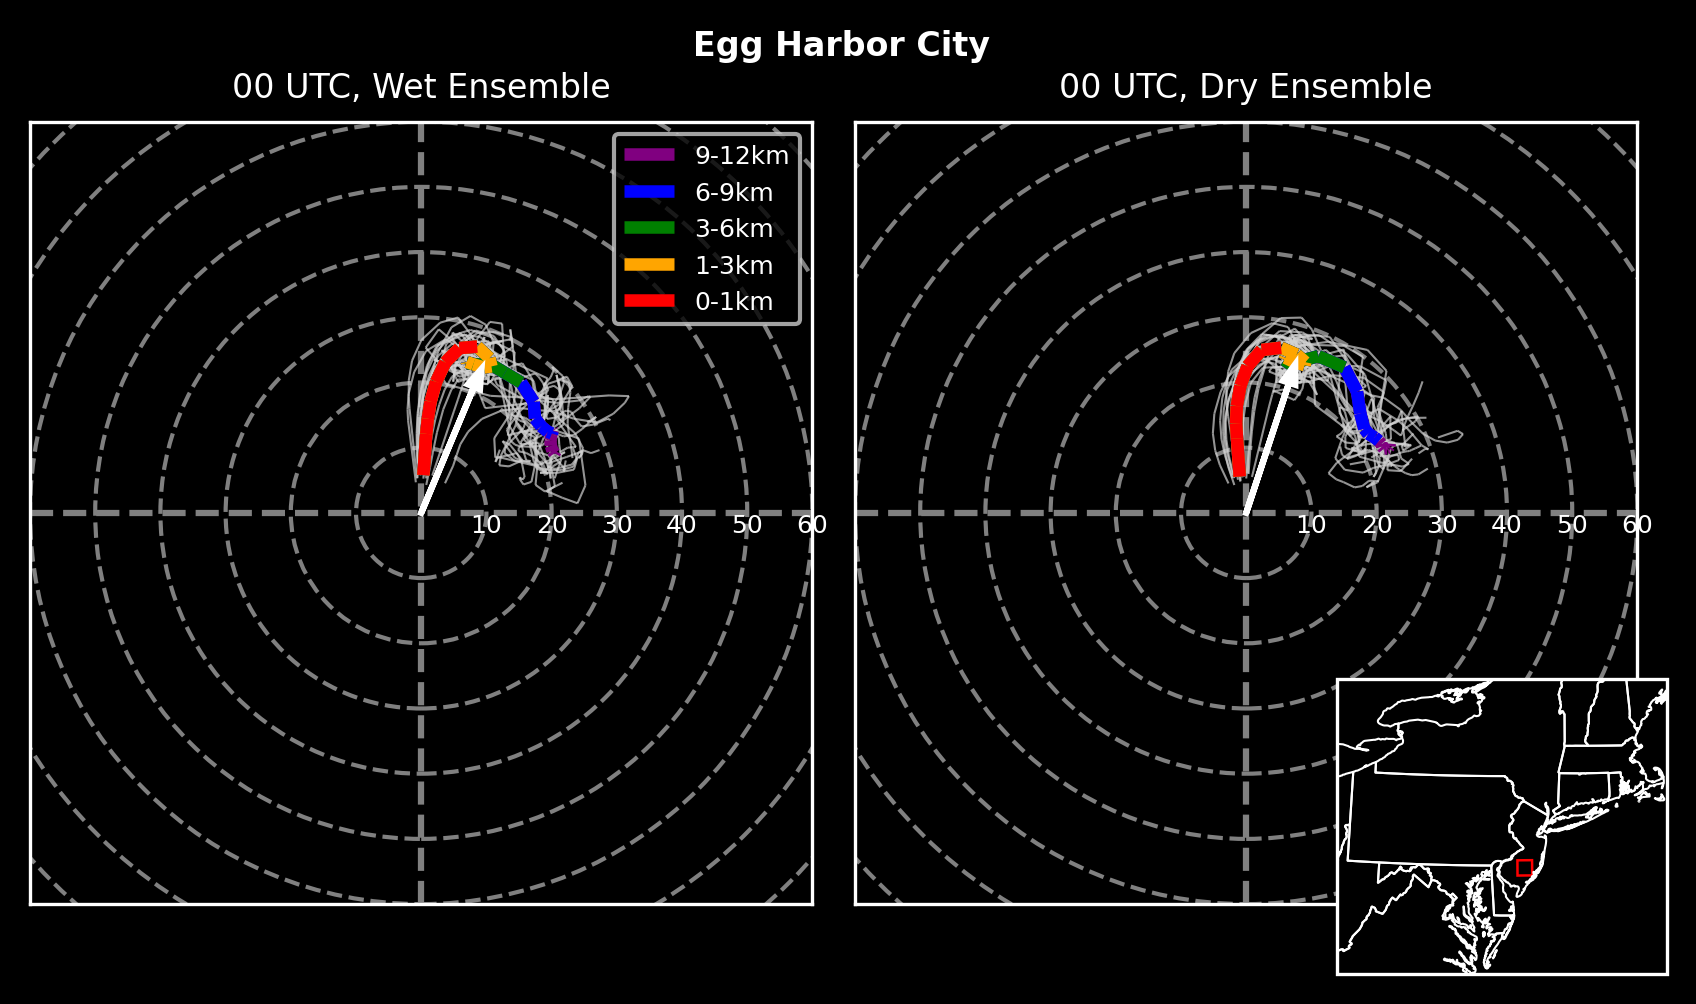

In [17]:
plot_hodographs_and_map(
    u_wet,
    v_wet,
    z_wet,
    u_dry,
    v_dry,
    z_dry,
    u_wet_mean,
    v_wet_mean,
    z_wet_mean,
    u_dry_mean,
    v_dry_mean,
    z_dry_mean,
    lat_coarse,
    lon_coarse,
    nx_ind,
    ny_ind,
    suptitle="Egg Harbor City",
)


### SE PA

In [18]:
# First, find the nx and ny of reading pa
rea_lat, rea_lon = 40.3356, -75.9269

# Calculate Euclidean distance and find the nearest indices
distance = np.sqrt((lat_coarse - rea_lat) ** 2 + (lon_coarse - rea_lon) ** 2)
rea_inds = distance.argmin(dim=["ny", "nx"])
ny_ind, nx_ind = int(rea_inds["nx"]), int(rea_inds["ny"])

u_wet = xr.concat(extract_data("u", wettest, ny_ind, nx_ind), dim=init)
v_wet = xr.concat(extract_data("v", wettest, ny_ind, nx_ind), dim=init)
z_wet = xr.concat(extract_data("z_agl", wettest, ny_ind, nx_ind), dim=init)

u_dry = xr.concat(extract_data("u", driest, ny_ind, nx_ind), dim=init)
v_dry = xr.concat(extract_data("v", driest, ny_ind, nx_ind), dim=init)
z_dry = xr.concat(extract_data("z_agl", driest, ny_ind, nx_ind), dim=init)

# Calculate ensemble means
u_wet_mean, u_dry_mean = u_wet.mean(dim=["ne", "init"]), u_dry.mean(dim=["ne", "init"])
v_wet_mean, v_dry_mean = v_wet.mean(dim=["ne", "init"]), v_dry.mean(dim=["ne", "init"])
z_wet_mean, z_dry_mean = z_wet.mean(dim=["ne", "init"]), z_dry.mean(dim=["ne", "init"])


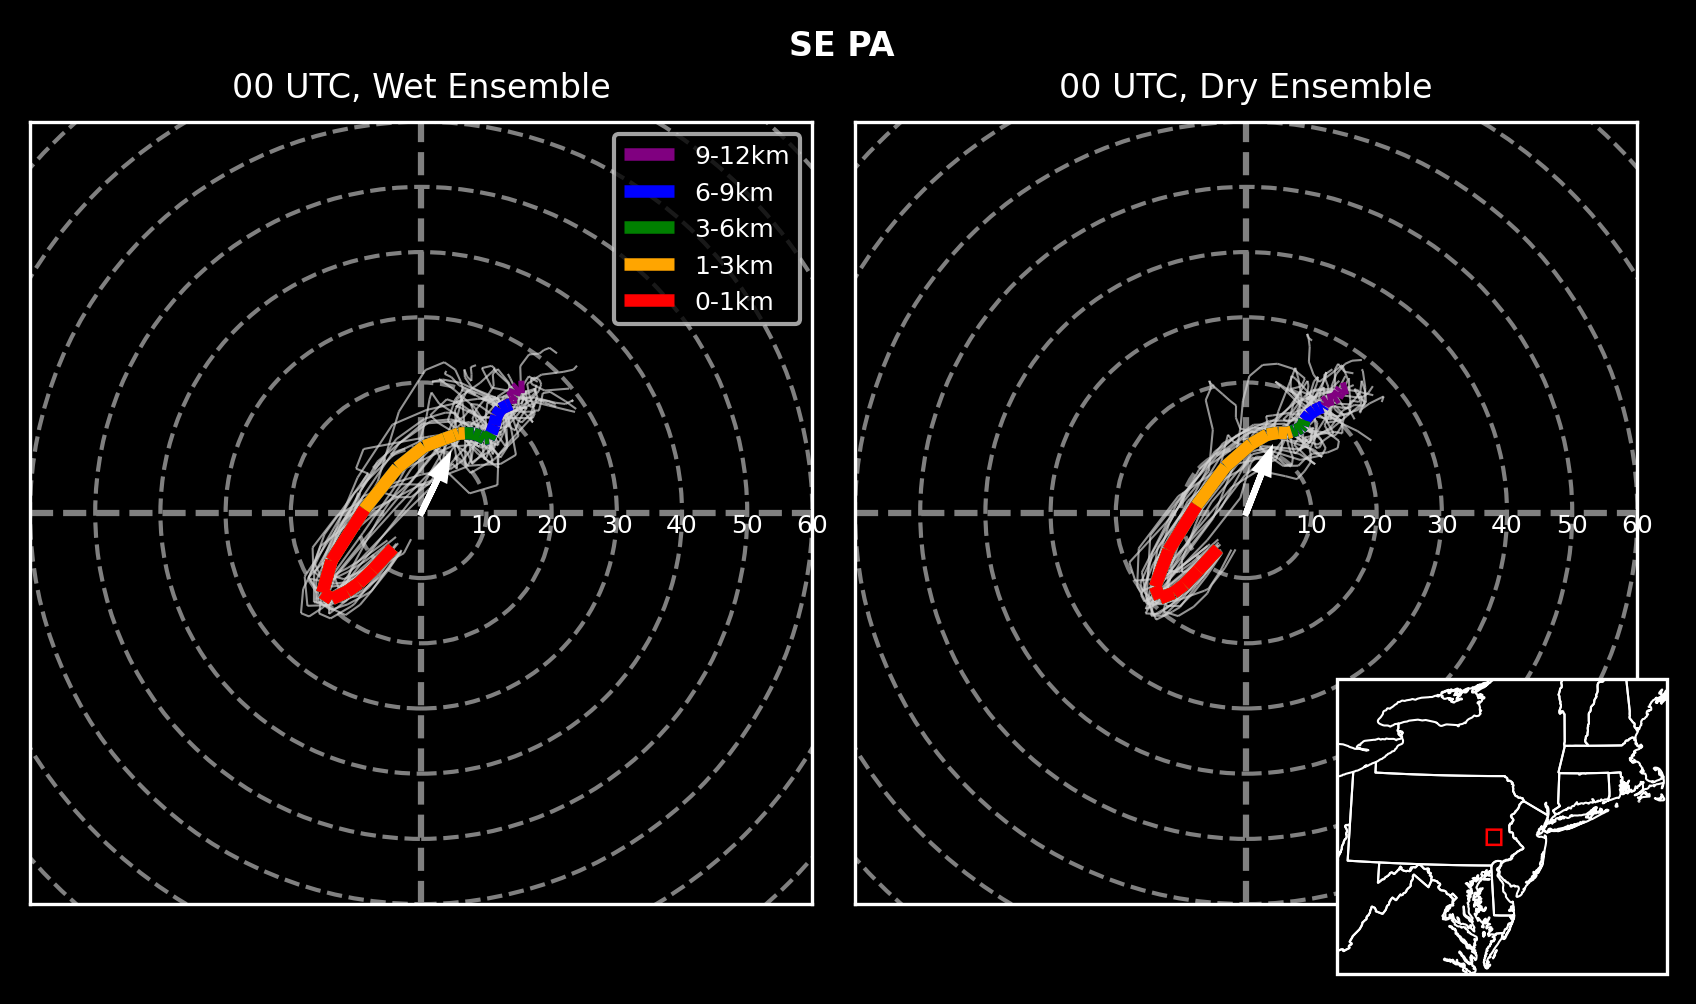

In [19]:
plot_hodographs_and_map(
    u_wet,
    v_wet,
    z_wet,
    u_dry,
    v_dry,
    z_dry,
    u_wet_mean,
    v_wet_mean,
    z_wet_mean,
    u_dry_mean,
    v_dry_mean,
    z_dry_mean,
    lat_coarse,
    lon_coarse,
    nx_ind,
    ny_ind,
    suptitle="SE PA",
)


### LI

In [20]:
# First, find the nx and ny of islip LI
isl_lat, isl_lon = 40.7298, -73.2106

# Calculate Euclidean distance and find the nearest indices
distance = np.sqrt((lat_coarse - isl_lat) ** 2 + (lon_coarse - isl_lon) ** 2)
isl_inds = distance.argmin(dim=["ny", "nx"])
ny_ind, nx_ind = int(isl_inds["nx"]), int(isl_inds["ny"])

u_wet = xr.concat(extract_data("u", wettest, ny_ind, nx_ind), dim=init)
v_wet = xr.concat(extract_data("v", wettest, ny_ind, nx_ind), dim=init)
z_wet = xr.concat(extract_data("z_agl", wettest, ny_ind, nx_ind), dim=init)

u_dry = xr.concat(extract_data("u", driest, ny_ind, nx_ind), dim=init)
v_dry = xr.concat(extract_data("v", driest, ny_ind, nx_ind), dim=init)
z_dry = xr.concat(extract_data("z_agl", driest, ny_ind, nx_ind), dim=init)

# Calculate ensemble means
u_wet_mean, u_dry_mean = u_wet.mean(dim=["ne", "init"]), u_dry.mean(dim=["ne", "init"])
v_wet_mean, v_dry_mean = v_wet.mean(dim=["ne", "init"]), v_dry.mean(dim=["ne", "init"])
z_wet_mean, z_dry_mean = z_wet.mean(dim=["ne", "init"]), z_dry.mean(dim=["ne", "init"])


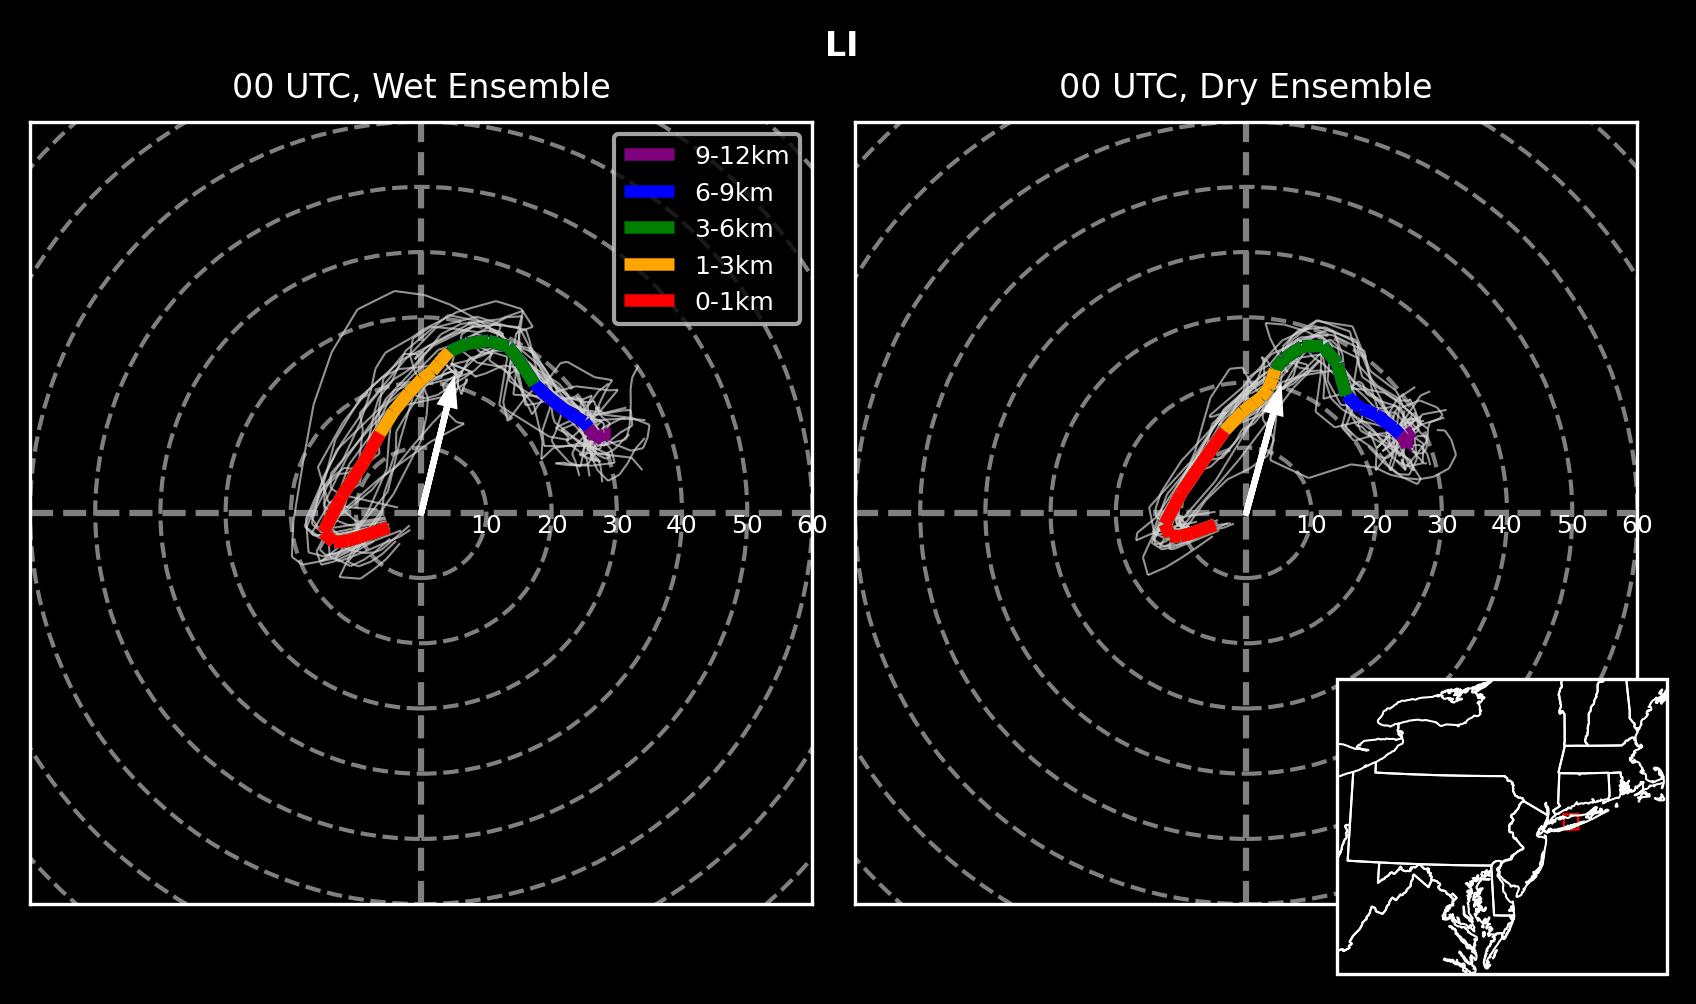

In [21]:
plot_hodographs_and_map(
    u_wet,
    v_wet,
    z_wet,
    u_dry,
    v_dry,
    z_dry,
    u_wet_mean,
    v_wet_mean,
    z_wet_mean,
    u_dry_mean,
    v_dry_mean,
    z_dry_mean,
    lat_coarse,
    lon_coarse,
    nx_ind,
    ny_ind,
    suptitle="LI",
)


### Downstate NY

In [22]:
# First, find the nx and ny of poughkeepsie
pou_lat, pou_lon = 41.7004, -73.9210

# Calculate Euclidean distance and find the nearest indices
distance = np.sqrt((lat_coarse - pou_lat) ** 2 + (lon_coarse - pou_lon) ** 2)
pou_inds = distance.argmin(dim=["ny", "nx"])
ny_ind, nx_ind = int(pou_inds["nx"]), int(pou_inds["ny"])

u_wet = xr.concat(extract_data("u", wettest, ny_ind, nx_ind), dim=init)
v_wet = xr.concat(extract_data("v", wettest, ny_ind, nx_ind), dim=init)
z_wet = xr.concat(extract_data("z_agl", wettest, ny_ind, nx_ind), dim=init)

u_dry = xr.concat(extract_data("u", driest, ny_ind, nx_ind), dim=init)
v_dry = xr.concat(extract_data("v", driest, ny_ind, nx_ind), dim=init)
z_dry = xr.concat(extract_data("z_agl", driest, ny_ind, nx_ind), dim=init)

# Calculate ensemble means
u_wet_mean, u_dry_mean = u_wet.mean(dim=["ne", "init"]), u_dry.mean(dim=["ne", "init"])
v_wet_mean, v_dry_mean = v_wet.mean(dim=["ne", "init"]), v_dry.mean(dim=["ne", "init"])
z_wet_mean, z_dry_mean = z_wet.mean(dim=["ne", "init"]), z_dry.mean(dim=["ne", "init"])


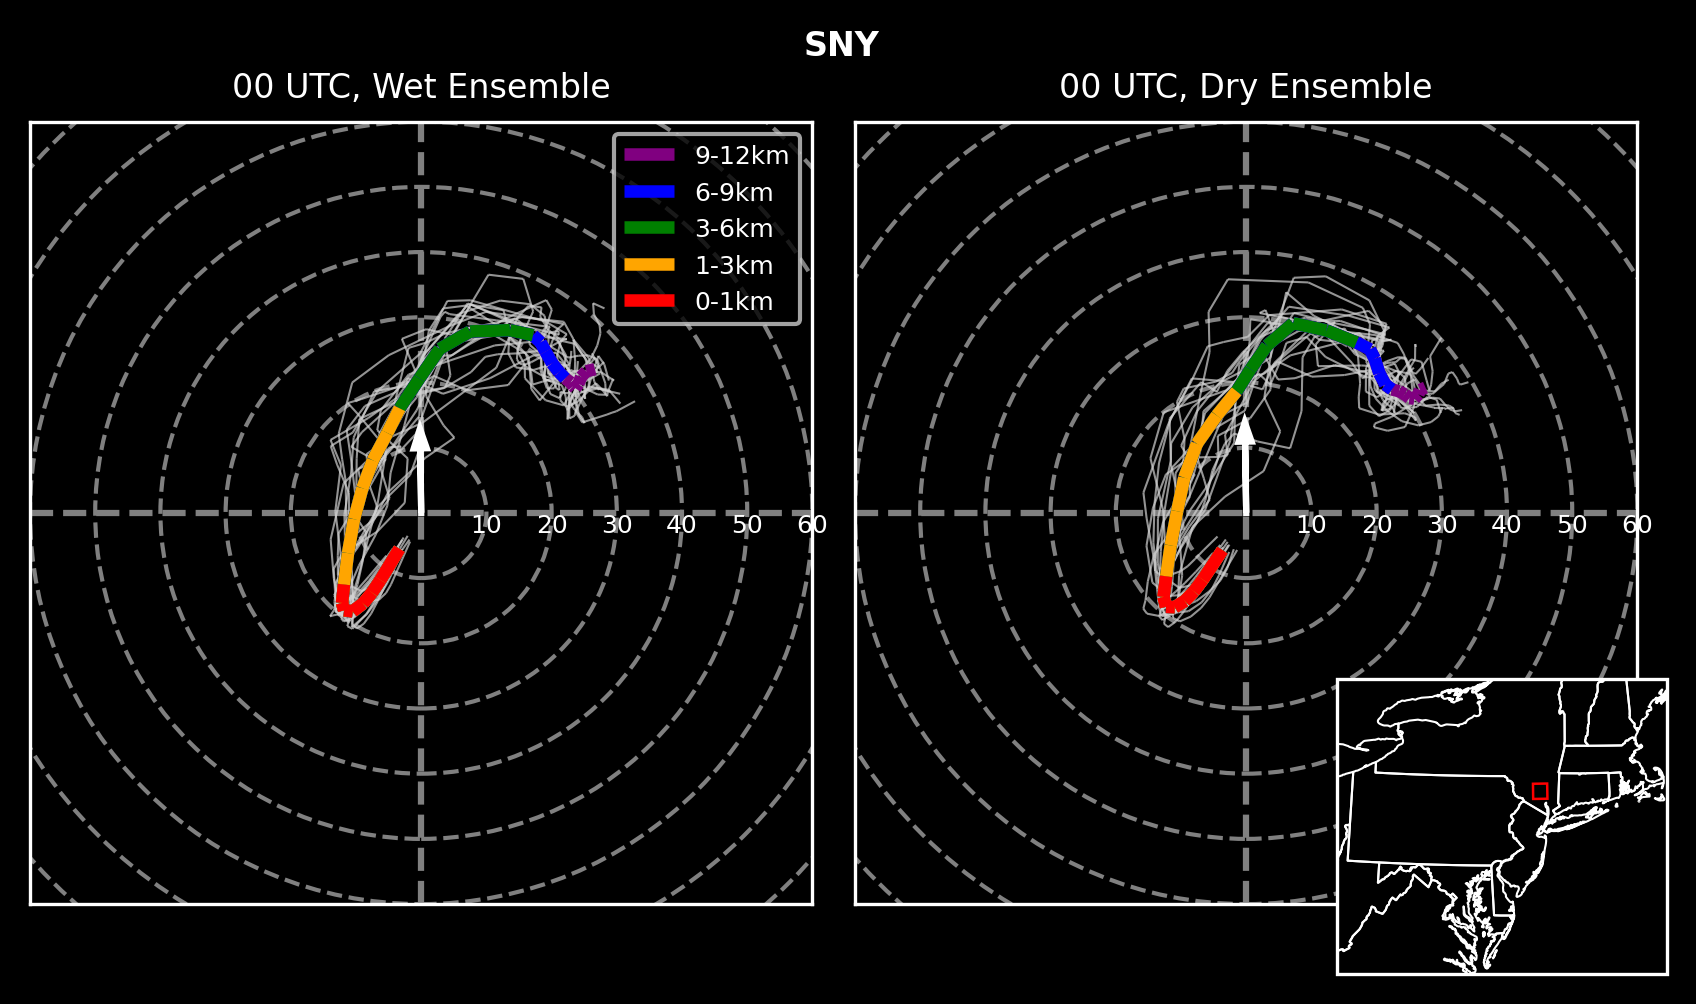

In [23]:
plot_hodographs_and_map(
    u_wet,
    v_wet,
    z_wet,
    u_dry,
    v_dry,
    z_dry,
    u_wet_mean,
    v_wet_mean,
    z_wet_mean,
    u_dry_mean,
    v_dry_mean,
    z_dry_mean,
    lat_coarse,
    lon_coarse,
    nx_ind,
    ny_ind,
    suptitle="SNY",
)


### CT

In [40]:
# First, find the nx and ny of hartford
hrt_lat, hrt_lon = 41.7658, -72.6734

# Calculate Euclidean distance and find the nearest indices
distance = np.sqrt((lat_coarse - hrt_lat) ** 2 + (lon_coarse - hrt_lon) ** 2)
hrt_inds = distance.argmin(dim=["ny", "nx"])
ny_ind, nx_ind = int(hrt_inds["nx"]), int(hrt_inds["ny"])

u_wet = xr.concat(extract_data("u", wettest, ny_ind, nx_ind), dim=init)
v_wet = xr.concat(extract_data("v", wettest, ny_ind, nx_ind), dim=init)
z_wet = xr.concat(extract_data("z_agl", wettest, ny_ind, nx_ind), dim=init)

u_dry = xr.concat(extract_data("u", driest, ny_ind, nx_ind), dim=init)
v_dry = xr.concat(extract_data("v", driest, ny_ind, nx_ind), dim=init)
z_dry = xr.concat(extract_data("z_agl", driest, ny_ind, nx_ind), dim=init)

# Calculate ensemble means
u_wet_mean, u_dry_mean = u_wet.mean(dim=["ne", "init"]), u_dry.mean(dim=["ne", "init"])
v_wet_mean, v_dry_mean = v_wet.mean(dim=["ne", "init"]), v_dry.mean(dim=["ne", "init"])
z_wet_mean, z_dry_mean = z_wet.mean(dim=["ne", "init"]), z_dry.mean(dim=["ne", "init"])


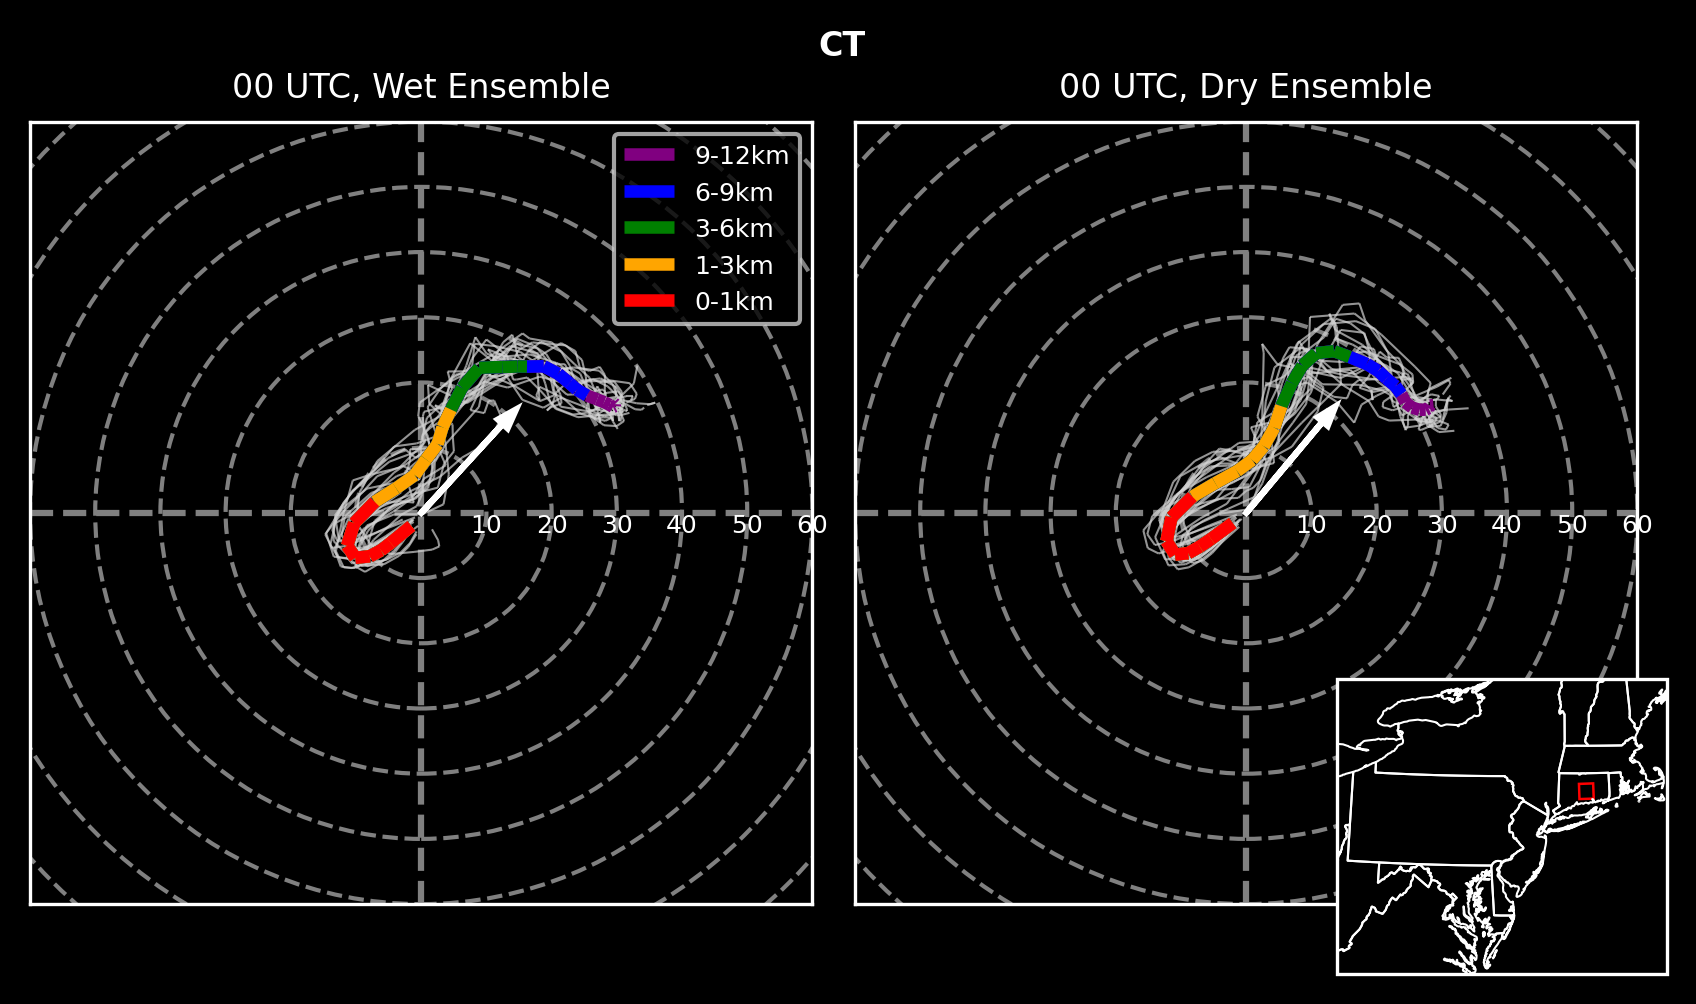

In [41]:
plot_hodographs_and_map(
    u_wet,
    v_wet,
    z_wet,
    u_dry,
    v_dry,
    z_dry,
    u_wet_mean,
    v_wet_mean,
    z_wet_mean,
    u_dry_mean,
    v_dry_mean,
    z_dry_mean,
    lat_coarse,
    lon_coarse,
    nx_ind,
    ny_ind,
    suptitle="CT",
)
